In [1]:
import tensorflow as tf
import shutil
import matplotlib.pyplot as plt
from sklearn.utils import resample
import numpy as np 
import pandas as pd 
import os 
from os import listdir
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import to_categorical
from keras.preprocessing import image
from keras import callbacks
from keras import optimizers
#from keras.engine import Model
from keras.layers import Dropout, Flatten, Dense
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
#from keras.applications import VGG16
#from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from tqdm import tqdm
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
from keras.applications.vgg16 import VGG16

In [3]:
from keras.models import Model

In [4]:
# for model analysis
import tensorflow_model_analysis as tfma

In [5]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [6]:
benign=getListOfFiles('C:/KOUSHIK/CROSS_VALIDATION/DataSet/BreaKHisBin/Benign')
malignent=getListOfFiles('C:/KOUSHIK/CROSS_VALIDATION/DataSet/BreaKHisBin/Malignant')

In [7]:
input_shape = (48, 48, 3)

In [8]:
data = pd.DataFrame(index=np.arange(0, len(benign)+len(malignent)), columns=["image", "target"])
k=0
for c in [0,1]:
    if c==1:
        for m in range(len(benign)):
            data.iloc[k]["image"] = benign[m]
            data.iloc[k]["target"] = 0
            k+=1
    else:
        for m in range(len(malignent)):
            data.iloc[k]["image"] = malignent[m]
            data.iloc[k]["target"] = 1
            k+=1

In [9]:
data["target"].value_counts()

1    1370
0     625
Name: target, dtype: int64

In [10]:
train_image=[]
y=[]

In [11]:
for i in tqdm(range(data.shape[0])):
    img = image.load_img(data['image'].iloc[i], target_size=input_shape, grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

100%|██████████| 1995/1995 [00:38<00:00, 51.92it/s]


In [65]:
X = np.array(train_image)
y = data.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2, shuffle=True)

In [74]:
y_train = keras.utils.np_utils.to_categorical(y_train, 2)
y_test = keras.utils.np_utils.to_categorical(y_test, 2)
y_val = keras.utils.np_utils.to_categorical(y_val, 2)

In [14]:
X_train.shape, X_test.shape, X_val.shape

((1596, 48, 48, 3), (319, 48, 48, 3), (80, 48, 48, 3))

# Model Building

In [15]:
# we build the base model
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [16]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in base_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

Layer input_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [17]:
# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)
model = Model(base_model.input, x )

In [18]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam(learning_rate=0.001)

In [19]:
# We compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# We compile the model with AUC
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

# Train the model

In [76]:
# We start the training
epochs = 10
batch_size = 64
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          epochs=epochs)

Epoch 1/10
25/25 [==============================] - 6s 253ms/step - loss: 0.3776 - auc: 0.9119 - val_loss: 0.3543 - val_auc: 0.9299
Epoch 2/10
25/25 [==============================] - 6s 242ms/step - loss: 0.3659 - auc: 0.9176 - val_loss: 0.3367 - val_auc: 0.9320
Epoch 3/10
25/25 [==============================] - 6s 250ms/step - loss: 0.3508 - auc: 0.9248 - val_loss: 0.3137 - val_auc: 0.9377
Epoch 4/10
25/25 [==============================] - 6s 249ms/step - loss: 0.3374 - auc: 0.9314 - val_loss: 0.3163 - val_auc: 0.9376
Epoch 5/10
25/25 [==============================] - 6s 254ms/step - loss: 0.3231 - auc: 0.9378 - val_loss: 0.3477 - val_auc: 0.9280
Epoch 6/10
25/25 [==============================] - 6s 257ms/step - loss: 0.3230 - auc: 0.9378 - val_loss: 0.3037 - val_auc: 0.9423
Epoch 7/10
25/25 [==============================] - 6s 260ms/step - loss: 0.3213 - auc: 0.9374 - val_loss: 0.3326 - val_auc: 0.9329
Epoch 8/10
25/25 [==============================] - 7s 265ms/step - loss: 0.

<AxesSubplot:>

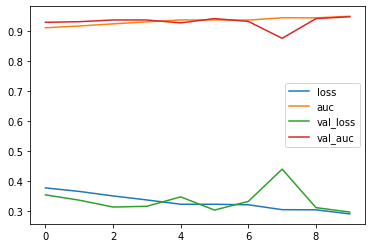

In [78]:
history_df = pd.DataFrame(history.history)
history_df.plot()

# Test the model

In [79]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10/10 [==============================] - 1s 116ms/step - loss: 0.4733 - auc: 0.8729
Test loss: 0.4733351469039917
Test accuracy: 0.8729080557823181


In [80]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [81]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [102]:
y_pred = model.predict(X_test)
ytest_pred = keras.utils.np_utils.to_categorical(y_pred, 2)
y_pred

array([[1.54814959e-01, 8.30394268e-01],
       [1.18638903e-01, 8.81903946e-01],
       [4.76095676e-02, 9.48639750e-01],
       [2.32927829e-01, 7.75502682e-01],
       [2.52070427e-01, 7.53266692e-01],
       [2.97764540e-02, 9.69081283e-01],
       [1.82699621e-01, 8.05640101e-01],
       [2.34866142e-03, 9.97206330e-01],
       [6.19417012e-01, 3.76243651e-01],
       [7.73929954e-02, 9.21815515e-01],
       [3.89421880e-02, 9.57580686e-01],
       [4.32143509e-02, 9.57568228e-01],
       [2.59314179e-02, 9.73858118e-01],
       [4.07655835e-02, 9.54994321e-01],
       [4.00749147e-01, 6.09680176e-01],
       [1.11191034e-01, 8.86376381e-01],
       [9.75486755e-01, 1.84448659e-02],
       [3.90172601e-02, 9.57602143e-01],
       [6.58279717e-01, 3.24602157e-01],
       [1.91239417e-02, 9.79527473e-01],
       [4.57822084e-01, 5.42888403e-01],
       [6.86748028e-02, 9.20628250e-01],
       [1.00768834e-01, 8.97798538e-01],
       [5.29851317e-02, 9.43081796e-01],
       [1.520121

In [103]:
ytest_pred

array([[[1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.]]], dtype=float32)

In [98]:
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

RF test roc-auc: 0.5
